## This notebook has been uploaded to GitHub
#### https://github.com/silverboris/DataScienceClass/blob/master/FP3_Boris_Serebrinskiy_TechnicalModeling.ipynb



## MS Data Science Class
### Final Project, Part 3. Technical Writeup / Modeling Performance
### Author: Boris Serebrinskiy
### Date: Dec 1-10, 2018

### Project Name: Predicting cost of solar panel installations based on system size, progress in solar panel development, economic incentives, electric rates.

### Problem Statement: this essentially matches Project Name - What are the effects of technological progress and economical factors on costs of solar energy systems?

### Hypothesis: Solar energy costs will continue to decrease. They primarily depend on efficiency of the solar panels, size of the systems, and economic incentives. 


### This notebooks builds up on the results of EDA of FP2. We will be using dataset derived from  Part1 and Part2 data preparation ( see FP2_Boris_Serebrinskiy_EDA and FP2_Boris_Serebrinskiy_EDA_Installment2)

### In Part2 we have derived final dataset called solar_electric_construction_nasa_final.csv

In [264]:
#import packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from string import ascii_letters

sns.set()




## EDA Summary

1. We have merged data for solar panel installations, electric rates by state and year, NASA solar radiation by using mean rate by State, and construction cost index by Year/Month
2. We have added calculated fields like "% of incentive", "Cost Per KW", and "Clean Price - cost after rebates" based on data for tax and rebates for each installation.
3. We have isolated Residential installations with Cost Per KW under USD10,000/kw to eliminate outliers, with sizes of installations between 1 and 20Kw and prices between 10,000 and 100,000.
4. EDA shows clear dependencies between Cost Per KW, Size and Efficiency.
5. There are also historical trends with Efficiency growing, and CostPerKW falling year over year.
6. We will not be exploring dependencies due to geogrpahy, State, Zip.
7. Data for CostPerKW appears to be normally distributed, with 4,428 mean per 1Kw
8. Data for CleanPrice is also normally distributed, with mean about 28,000 per installation


In [265]:
DATA_FILE="solar_electric_construction_nasa_final.csv"

In [266]:
df_base_data = pd.read_csv('solar_electric_construction_nasa_final.csv')
df_base_data["Date"] = pd.to_datetime(df_base_data["Date"])


In [267]:
df_base_data.columns

Index(['Unnamed: 0', 'Size', 'price', 'CleanPrice', 'efficiency', 'CostPerKW',
       'IncentivePct', 'State', 'zip', 'Year', 'ResidentialRate',
       'SolarRadiation', 'Month', 'Date', 'ConstructionPriceIndex',
       'ROIYears'],
      dtype='object')

## We will model prediction of CleanPrice of a solar installation (target variable/outcome), with Efficiency, Size, IncentivePct, ResidentialRate,ConstructionPriceIndex being the prediction metrics. We will also explore Time Series aspect of the data.

## Create hold out data set for the final model verification

In [50]:
df_holdout = df_base_data.sample( 1000, random_state=1 )

In [51]:
df_model = df_base_data.drop(df_holdout.index)

In [270]:
df_base_data.set_index(df_base_data.Date, inplace=True)
df_model.describe()

,Size,CleanPrice,efficiency,IncentivePct,Year,ResidentialRate,ConstructionPriceIndex,ROIYears
count,8307.000000,8307.000000,8307.000000,8307.000000,8307.000000,8307.000000,8307.000000,8307.000000
mean,6.656310,28170.086157,0.169398,0.076679,2014.778259,16.925026,114.655736,14.730059
std,2.999774,13154.955504,0.019428,0.120214,2.155678,2.068262,8.978612,5.301399
min,1.077076,1180.400000,0.102778,-0.078681,2004.000000,10.020000,90.500000,0.722406
25%,4.500000,18779.595676,0.157407,0.000000,2014.000000,16.620000,111.300000,11.344443
50%,6.100000,25455.000000,0.164516,0.035357,2015.000000,17.320000,114.400000,14.104422
75%,8.304886,34786.076682,0.181452,0.129095,2016.000000,18.150000,123.400000,17.070648
max,19.750000,98460.000000,0.220859,0.958925,2017.000000,20.380000,127.300000,93.020508


### Let's take columns we are interested in for the modeling analysis

In [53]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8307 entries, 0 to 9306
Data columns (total 16 columns):
Unnamed: 0                8307 non-null int64
Size                      8307 non-null float64
price                     8307 non-null float64
CleanPrice                8307 non-null float64
efficiency                8307 non-null float64
CostPerKW                 8307 non-null float64
IncentivePct              8307 non-null float64
State                     8307 non-null object
zip                       8307 non-null int64
Year                      8307 non-null int64
ResidentialRate           8307 non-null float64
SolarRadiation            8307 non-null float64
Month                     8307 non-null int64
Date                      8307 non-null datetime64[ns]
ConstructionPriceIndex    8307 non-null float64
ROIYears                  8307 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 1.1+ MB


In [141]:
model_cols = [ 'Size', 'CleanPrice', 'efficiency',  \
       'IncentivePct', 'State', 'Year', 'ResidentialRate', \
         'ConstructionPriceIndex', 'ROIYears']

In [142]:
df_model = df_model[model_cols]

In [143]:
df_holdout = df_holdout[model_cols]

## Correlation Coefficient Analysis shows very high positive correlation between Size and CleanPrice; 
## ResidentialRate and ConstructionPriceIndex (due to both increasing year over year);
## Efficiency and ConstructionPriceIndex (due to both increasing year over year);
## There does not appear to be any correlation between IncentivePct and Size (incentives dont depend on a size of the installations)
## There appears to be multiple metrics that multicolinear, we will explore that further

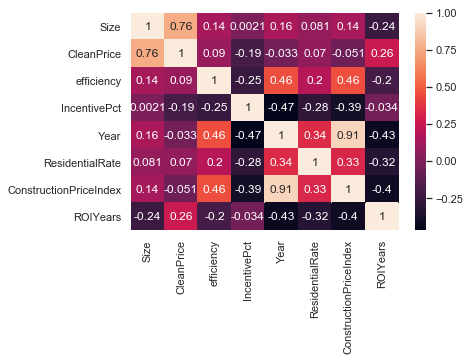

In [144]:
# heatmap
sns.heatmap(df_model.corr(), annot=True)

## Render two strongest variables

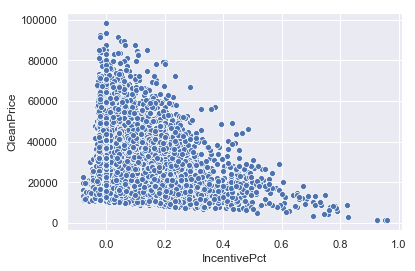

In [145]:
# Information about the data
sns.scatterplot(data=df_model, x="IncentivePct",y="CleanPrice")

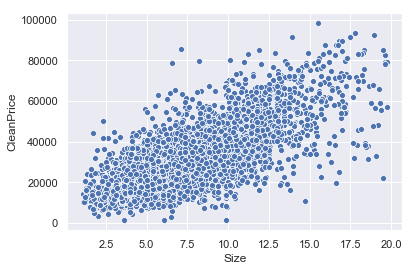

In [146]:
# Information about the data
sns.scatterplot(data=df_model, x="Size",y="CleanPrice")

In [156]:
X=df_model.drop(['CleanPrice','ROIYears', 'Year', 'State'], axis=1)
# solve for CleanPrice
y_price = df_model.CleanPrice

# solve for ROI
y_roi=df_model.ROIYears

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [158]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [159]:
from sklearn.model_selection import cross_val_score, train_test_split

In [160]:
from sklearn.grid_search import GridSearchCV

In [161]:
from sklearn.preprocessing import StandardScaler

In [162]:
lr=LinearRegression()

In [163]:
cv_score = cross_val_score(lr,X,y_price,cv=5)

In [164]:
cv_score

array([0.73552441, 0.61377559, 0.62259915, 0.73065034, 0.66754206])

## Linear Regression model above produces CV score of about 0.6, this means our other models should be at least as good or better than 0.6. It is possible LR is overfitting.

In [165]:
cv_score_mae=cross_val_score(lr,X,y_price,cv=5,scoring="neg_mean_absolute_error")

In [166]:
cv_score_mae.mean() 

-5454.543159864105

## Using test and train split sets to fit and test the model

In [167]:
X_train, X_test,y_train, y_test= train_test_split(X, y_price, random_state=1)

In [168]:
lr=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [169]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [170]:
lrpred=lr.predict(X_test)

In [171]:
r2_score(lrpred, y_test)

0.5390538098545199

In [172]:
ypred =lr.predict(X)

In [173]:
from sklearn.metrics import r2_score , mean_squared_error


In [174]:
# run r2 for actual vs predicted mileage
r2_score(y_price, ypred)

0.6864023018694976

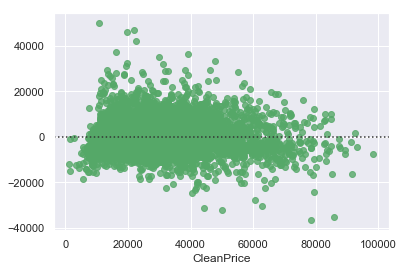

In [175]:
# Residual = Actual Observation - Expected Prediction

sns.residplot(y_price,ypred, color='g')

In [176]:
mean_squared_error(y_price,ypred)

54262443.84318078

##  using using a concave function such as  logY we will redo the model 

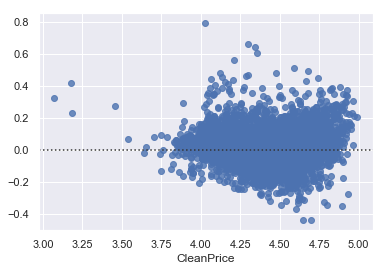

In [177]:
# Log transformation

ylog=np.log10(y_price+1)


# Fitting the log transformed model
lr.fit(X,ylog)

ypred= lr.predict(X)

sns.residplot(ylog,ypred)

In [178]:
# Print metrics
r2_score(ylog,ypred)

0.664707698525276

In [179]:
mean_squared_error(y_price,ypred)

966334088.4449822

## The MSE did not improve with log10

#### Create a cross-valiation with five folds.

In [180]:
from sklearn import model_selection

In [181]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [182]:
lr= LinearRegression()

In [183]:
from sklearn.model_selection import cross_val_score


print(np.mean(-cross_val_score(lr, X, y_price, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y_price, cv=kf)))

54318933.07959783
0.685544066531701


# Decision Trees using GridSearch with Cross Validation

In [184]:
dt = DecisionTreeRegressor()
param_d = {"max_depth": list(range(2,25))}
grid_dt_mae = GridSearchCV(dt,param_grid=param_d, cv=5,scoring="neg_mean_absolute_error")


In [185]:
grid_dt_mae.fit(X, y_price)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [186]:
grid_dt_mae.best_params_

{'max_depth': 9}

In [187]:
grid_dt_mae.best_score_ * -1

5192.265723891452

In [188]:
dt_best = DecisionTreeRegressor(max_depth=grid_dt_mae.best_params_["max_depth"])

In [189]:
dt_best.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [190]:
dtpredict=dt_best.predict(X_test)

In [191]:
mean_absolute_error(y_test, dtpredict)

4755.262381626454

In [192]:
X.columns

Index(['Size', 'efficiency', 'IncentivePct', 'ResidentialRate',
       'ConstructionPriceIndex'],
      dtype='object')

In [194]:
Xh= df_holdout[['Size', 'efficiency', 'IncentivePct', 'ResidentialRate',
       'ConstructionPriceIndex']]
yh = df_holdout.CleanPrice
dtpredict_holdout = dt_best.predict(Xh)

In [195]:
r2_score(df_holdout.CleanPrice,dtpredict_holdout)

0.698115687557268

## Feature Importances

In [196]:
sorted(zip(dt_best.feature_importances_, X.columns), reverse=True)

[(0.7037885989532708, 'Size'),
 (0.16810224276755287, 'IncentivePct'),
 (0.06744712341535301, 'ConstructionPriceIndex'),
 (0.03537234309137171, 'efficiency'),
 (0.025289691772451623, 'ResidentialRate')]

# 2nd approach to Decision Tree modeling - without GridSearchCV



In [208]:
#Find the best max_depth for a decision tree using cross-validation:

# list of values to try for max_depth
max_depth_range = range(1, 25)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []


# use 5-fold cross-validation with each value of max_depth

for depth in max_depth_range:
    treereg=DecisionTreeRegressor(max_depth=depth,random_state=1)
    MSE_scores=cross_val_score(treereg,X, y_price,cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

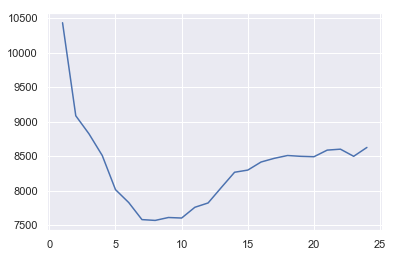

In [209]:
plt.plot(max_depth_range,RMSE_scores)
# best RMSE is at 9, so higher depth does not improve the model

In [211]:
# show the best RMSE and the corresponding max_depth
dt_auto= DecisionTreeRegressor(max_depth=9)
dt_auto=dt.fit(X,y_price)
dt_auto.score(X,y_price)


0.9994533182766037

In [212]:
dtpred=dt_auto.predict(X)

In [214]:
meanSquaredError=mean_squared_error(y_price, dtpred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = np.sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 94593.44406136592
RMSE: 307.5604722024043


In [215]:
# compute feature importances
pd.DataFrame({'feature':X.columns, 
              'importance':dt_auto.feature_importances_}).sort_values('importance', ascending = False)

,feature,importance
0,Size,0.634519
2,IncentivePct,0.178698
4,ConstructionPriceIndex,0.082567
1,efficiency,0.066965
3,ResidentialRate,0.037250


# Conclusion of Decision Tree analysis: we have one strong feature - Size - that forces DT to split on that feature, so all DTs are correlated on it. We will then use RandomForest to allow for Size to be ignored by some of the trees.

# Predicting CleanPrice with a Random Forest

# Tuning n_estimators - this can take a very long time - be careful


In [219]:
RUN_RANDOM_FORESTS = True

In [221]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
# list of values to try for n_estimators
estimator_range = range(10, 210, 10)



if RUN_RANDOM_FORESTS:
# list to store the average RMSE for each value of n_estimators
    RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators. Will take a while.

    for estimator in estimator_range:
        rfr = RandomForestRegressor(n_estimators=estimator, random_state=1)
        MSE_scores = cross_val_score(rfr, X, y_price, cv=5, scoring='neg_mean_squared_error')
        RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

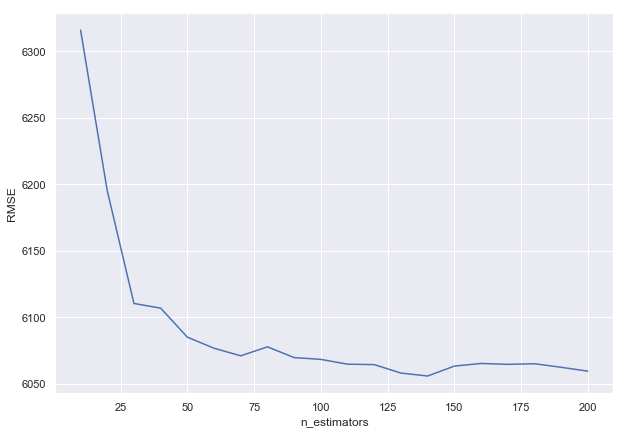

In [222]:

# plot max_features (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE');

#### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [227]:
# list of values to try for max_features
feature_range = range(1, len(X.columns))

if RUN_RANDOM_FORESTS:
    # list to store the average RMSE for each value of max_features
    RMSE_scores = []

    # use 5-fold cross-validation with each value of max_features (WARNING: SLOW!)
    for feature in feature_range:
        rfreg = RandomForestRegressor(n_estimators=130, max_features=feature, random_state=1)
        MSE_scores = cross_val_score(rfreg, X, y_price, cv=5, scoring='neg_mean_squared_error')
        RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

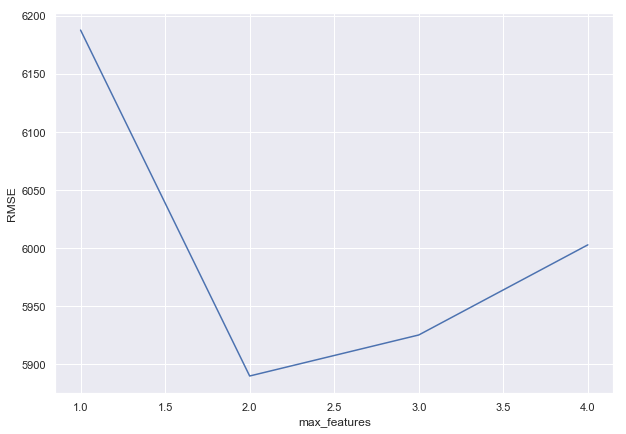

In [229]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE');

In [231]:
# list of values to try for max_features
feature_range = range(1, len(X.columns))

# list to store the average RMSE for each value of max_features
R2_scores = []

# use 5-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=130, max_features=feature, random_state=1)
    r2_scores = cross_val_score(rfreg, X, y_price, cv=5, scoring='r2')
    R2_scores.append(np.mean(r2_scores))

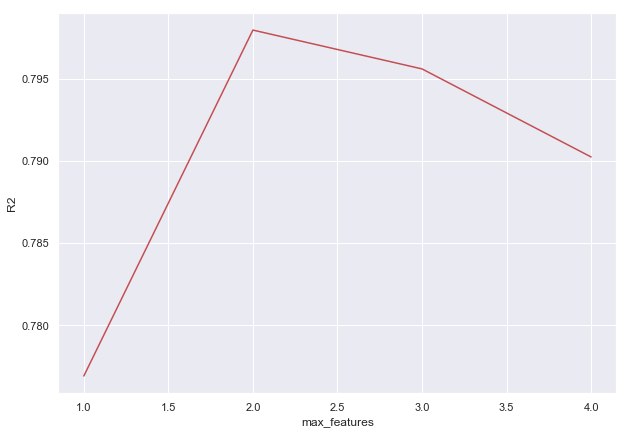

In [232]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.figure(figsize=(10, 7))
plt.plot(feature_range,R2_scores, color ='r' )
plt.xlabel('max_features')
plt.ylabel('R2');

#### Fitting a Random Forest with the best parameters

In [234]:
# Use the best n_estimators and max_features values
rfr = RandomForestRegressor(n_estimators=130, 
                              max_features=2,
                              oob_score=True,
                              random_state=1)
rfr.fit(X, y_price)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=130, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [235]:
# compute feature importances
pd.DataFrame({'feature':X.columns,
              'importance':rfr.feature_importances_}).sort_values('importance', ascending = False)

,feature,importance
0,Size,0.644747
2,IncentivePct,0.152315
1,efficiency,0.076981
4,ConstructionPriceIndex,0.074896
3,ResidentialRate,0.051061


In [236]:
# compute the out-of-bag R-squared score
rfr.oob_score_


0.8367006572154597

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X,y_price, random_state = 1)

In [239]:
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

In [240]:
# create a new feature matrix that only includes important features
X_train_imp =  SelectFromModel(rfr, threshold=0.05, prefit=True).transform(X_train)
X_test_imp =  SelectFromModel(rfr, threshold=0.05, prefit=True).transform(X_test)

In [241]:
# check the scores for a Random Forest that only includes important features
rfr_important = RandomForestRegressor(n_estimators=130, random_state=1)
rfr_important.fit(X_train_imp, y_train)
preds = rfr_important.predict(X_test_imp)
#r squared
print ("R2 is", rfr_important.score(X_test_imp, y_test))
print ("RMSE is", metrics.mean_squared_error(y_test, preds)**.5)

R2 is 0.8047845034882067
RMSE is 5893.564116949746


# How do we validate the model using holdout set?


In [248]:
# create a new feature matrix that only includes important features
X_holdout = df_holdout[['Size', 'efficiency', 'IncentivePct', 'ResidentialRate', 'ConstructionPriceIndex']]

In [249]:
y_holdout = df_holdout.CleanPrice

In [250]:
y_pred_holdout = rfr_important.predict(X_holdout)

In [252]:
print ("R2 is", rfr_important.score(X_holdout, y_holdout))

R2 is 0.8109800670150429


In [251]:
print ("RMSE is", metrics.mean_squared_error(y_holdout, y_pred_holdout)**.5)

RMSE is 5532.846611198167


# Validate the model using just New York State data

In [273]:
X = df_model[['Size', 'efficiency', 'IncentivePct', 'ResidentialRate', 'ConstructionPriceIndex']][df_model.State=='NY']

In [274]:
y = df_model[['CleanPrice']][df_model.State=='NY']

In [275]:
y_nys = rfr_important.predict(X)

In [276]:
print ("R2 is", rfr_important.score(X, y))

R2 is 0.9466374122095311


In [277]:
print ("RMSE is", metrics.mean_squared_error(y, y_nys)**.5)

RMSE is 3110.196686506939


# R2 and RMSE for NY State show even better model prediction compared to the whole/holdout set

# Validate the model using just 2017 data

In [278]:
X = df_model[['Size', 'efficiency', 'IncentivePct', 'ResidentialRate', 'ConstructionPriceIndex']][df_model.Year==2017]

In [279]:
y = df_model[['CleanPrice']][df_model.Year==2017]

In [281]:
y_2017 = rfr_important.predict(X)

In [282]:
print ("R2 is", rfr_important.score(X, y))

R2 is 0.9290425258515179


In [283]:
print ("RMSE is", metrics.mean_squared_error(y, y_2017)**.5)

RMSE is 3228.429565356222


# R2 and RMSE for 2017 show even better model prediction compared to the whole/holdout set

## Predict cost of installation built  with panel efficiency of 22% (0.22), Size of 8Kw, 25% rebate, 25c/Kwh electric rates. ????


In [256]:
X.columns

Index(['Size', 'efficiency', 'IncentivePct', 'ResidentialRate',
       'ConstructionPriceIndex'],
      dtype='object')

In [257]:
rfr.predict([[8,0.22,.25,25,130]])

array([28697.77856456])

## Predict cost of installation built with panel efficiency of 28% (0.22), Size of 8Kw, 10% rebate, 40c/Kwh electric rates. ????

In [255]:
rfr.predict([[8,0.28,.10,40,160]])

array([31582.62758945])

## Predict cost of installation built with panel efficiency of 10% (0.22), Size of 8Kw, 20% rebate, 20c/Kwh electric rates. ????

In [258]:
rfr.predict([[8,0.10,.20,20,110]])

array([33155.65726992])

## Conclusion - we have attempted to use simple linear regressions model, decision tree model and random tree regressor model. The latter provided us with the best R2 of 0.81. We have identified strongest features affecting the outcome Size, IncentivePct, efficiency, ConstructionPriceIndex, ResidentialRate, in descending order of importance. Lowest RMSE was observed at random forest depth of around 130 and maxfeature range of 2. 


# TREND Analysis

In [271]:
avg_annual_efficiency = df_base_data['efficiency'].resample('A').mean()
avg_monthly_CostPerKW = df_base_data['CostPerKW'].resample('M').mean()


avg_annual_size = df_base_data['Size'].resample('A').mean()
avg_annual_roi = df_base_data['ROIYears'].resample('A').mean()

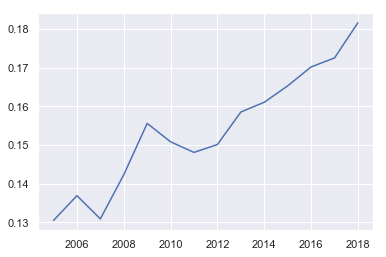

In [261]:
sns.lineplot(data=avg_annual_efficiency)

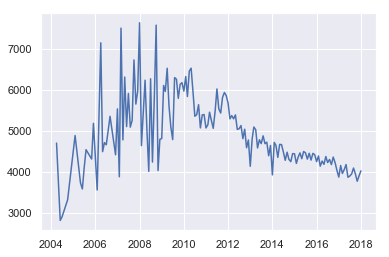

In [262]:
sns.lineplot(data=avg_monthly_CostPerKW)

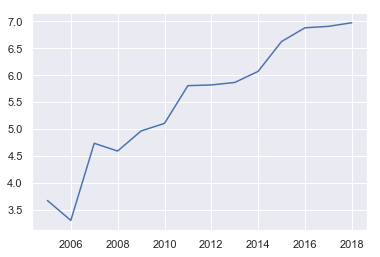

In [263]:
sns.lineplot(data=avg_annual_size)

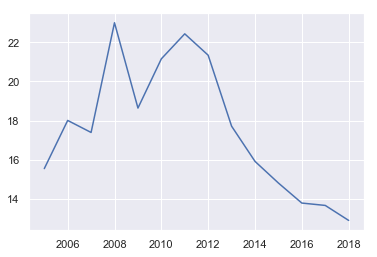

In [272]:
sns.lineplot(data=avg_annual_roi)

# Basic observations of the trend analysis: Panel Efficiency is rising, Cost Per KW dropping, ROI is vastly improving in the last 8 years, and average size of the installations is growing